In [32]:
#!pip install numpy matplotlib ipympl
import sys
print(sys.path)
if "../build/bliss/python" not in sys.path:
    sys.path.append("../build/bliss/python/")
import pybliss

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

['/home/benjb/.conda/envs/bliss_test/lib/python310.zip', '/home/benjb/.conda/envs/bliss_test/lib/python3.10', '/home/benjb/.conda/envs/bliss_test/lib/python3.10/lib-dynload', '', '/home/benjb/.conda/envs/bliss_test/lib/python3.10/site-packages', '/home/benjb/.conda/envs/bliss_test/lib/python3.10/site-packages/turbo_seti/find_doppler']


ModuleNotFoundError: No module named 'pybliss'

In [27]:
# bliss demo

# Import 
import os
os.chdir('/home/benjb/bliss-notebooks')

import bliss as pybliss
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import turbo_seti
import pandas as pd

## BLISS Demo: Voyager single coarse channel data from 2020

- Initialize a cadence object with the files as a list with structure: [[list of on files], [off], [off], [off]]
- Run flaggers
    - Flag the coarse channel roll off
    - Flag using spectral kurtosis as a metric of "RFI likelihood" (https://hyperseti.readthedocs.io/en/latest/pipeline/preprocessing.html#spectral-kurtosis-flagging, https://github.com/n-west/bliss/blob/458c53ef0b65e97a2aa070fd7fd1b351b0f593a7/bliss/estimators/include/estimators/spectral_kurtosis.hpp)
- Run noise estimation
- Set parameters for run and perform Doppler desmearing


In [2]:
# Accessing the public Voyager single coarse channel data
data_loc = "/datag/public/voyager_2020/single_coarse_channel"

# The structure here is so each observation target gets a list of files belonging to it
# [[list of on files], [off], [off], [off]]
# We have all been chatting usefulness of passing in a bldw cadence ID, or otherwise approaching some target-based cadence lookup
cadence_files = [[f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5",
                    f"{data_loc}/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5",
                    f"{data_loc}/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5"
                    ],
                    [f"{data_loc}/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5"],
                    [f"{data_loc}/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5"],
                    [f"{data_loc}/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5"]]

# Initialize a cadence object (also possible to initialize a single scan or single target/multiple scans)

#obs = pybliss.observation_target([f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"])
cadence = pybliss.cadence(cadence_files)

In [3]:
# Run flaggers. These are meant to take out coarse channel rolloff, bright RFI
# To improve noise accuracy

# Filter rolloff
# Pass the cadence object and a float, the rolloff_width, in this example 20% of channels
cadence = pybliss.flaggers.flag_filter_rolloff(cadence, .2)

# Spectral kurtosis calculated by frequency channel
# These are arbitrary for now, but the idea is to eliminate non-drifting signals and impulsive
# Interference, leaving in noise
cadence = pybliss.flaggers.flag_spectral_kurtosis(cadence, .02, 20)

In [4]:
# Create noise estimation options structure to hold estimator method and mask choice
# Use mask, defaults to True
# Use standard deviation to estimate noise (other option Median Absolute Deviation)
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev

# Run noise power estimators on cadence using flags and re-store in cadence object
cadence = pybliss.estimators.estimate_noise_power(cadence, noise_est_options)

In [5]:
# Set drift rate parameters

# NOTE: Currently uses Fourier bins, listed as "rate" because
# it sets the implicit max absolute drift

# Again create an options structure, set the parameters as attributes of the structure
# Sets desmear to True! Will notice if a certain drift rate crosses bins between time steps, and set a desmearing bandwidth
# Defaults to cpu version
# Will have a future option to collect RFI for future filtering, counting which kinds of RFI appear along the trajectory where and of what kind (i.e. present in which flagging mask)
opts = pybliss.integrate_drifts_options()
opts.desmear = True
opts.low_rate = -48
opts.high_rate = 48
opts.rate_step_size = 1


# Do the dedoppler integration, filling drift-frequency plane
cadence = pybliss.drift_search.integrate_drifts(cadence, opts)

INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec
INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec
INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec
INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec
INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec
INFO: Searching drift rates from 0.489804Hz/sec to -0.4796Hz/sec


#### DEEP DIVES IN BELOW COLLAPSED CELL

In [6]:
# DEEP DIVES

# Desmearing bandwidth is rounded to the nearest integer off of this; a slope of 0.5 will round up
"""
m = static_cast<float>(drift_channels) / static_cast<float>(maximum_drift_span);
"""

# Nathan has two versions in right now: cpu version and bland version
# Defaults to cpu version
# The bland version (and eventually cpu version) tracks RFI along a channel for later flagging
# NOTE: the below means that the desmearing should be a factor of sqrt(2) better right now.

"""
there's another quirk of desmearing and thresholds right now... 
I haven't yet adjusted the noise power for desmeared rates. 
If desmearing averages 2 bins per spectra together the noise power should 
drop by sqrt(2) and it's not currently happening. I think it's OK for now 
but it means the reported SNR drops when desmearing when I think it doesn't 
really drop
"""

# Three methods to select bins to set the desmear: Taylor tree, linear rounding, and Ken Houston's method (soon)
# Linear rounding is new to us. Compute trajectories, select points along that track
"""
/**
 * Methods to select bins along a linear track in time-frequency spectrum estimate.
 *
 * Spectrum estimates are laid out in a 2d array of shape [time, frequency].
 *
 * LINEAR_ROUND: use m=time rows / freq cols. Select freq column = round((1/m)*time step). For example, if the
 * spectrum estimate contains 8 time rows, we compute 8 doppler trajectories per frequency with slopes through
 * spectrum computed as
 * 0 (freq bins) / 8 (slow time spectra) = 0
 * 1 (freq bins) / 8 (slow time spectra) = 0.125
 * 2 (freq bins) / 8 (slow time spectra) = 0.25
 * 3 (freq bins) / 8 (slow time spectra) = 0.375
 * 4 (freq bins) / 8 (slow time spectra) = 0.5
 * 5 (freq bins) / 8 (slow time spectra) = 0.625
 * 6 (freq bins) / 8 (slow time spectra) = 0.75
 * 7 (freq bins) / 8 (slow time spectra) = 0.875
 *
 * While following a track to sum components, the frequency column for a step is freq index = round(m*step) so that
 * doppler drift 0: sum(spectrum[0, 0], spectrum[1, 0], spectrum[2, 0], spectrum[3, 0],
 *                      spectrum[4, 1], spectrum[5, 1], spectrum[6, 1], spectrum[7, 1]).
 * Special note: for values of 0.5 (such as for doppler track spanning 4 columns) this will round 0.5 up, which is
 * not always the default in some languages and libraries such as numpy and python which will round to the nearest
 * even which would give a slightly different track through spectrum.
 *
 * TAYLOR_TREE: use a tree-based method equivalent to turbo_seti, seticore, and first published by
 * Taylor, J. H, "A Sensitive Method for Detecting Dispersed Radio Emission." 1974 Astron. Astrophys. Suppl.
 *
 * HOUSTON: not implemented yet, but will follow Ken Houston's rules for rounding
 */
// enum class spectrum_sum_method {
//     LINEAR_ROUND,
//     TAYLOR_TREE,
//     HOUSTON,
// };
"""

# Linear rounding additional notes
# Thing only Carmen cares about: this is how people thought turboSETI was working until Owen + LOFAR folks noticed turboSETI's minimum drift rate resolution was different than the drift step
# Integrates directly like hyperseti, instead of dedrifting spectra and summing them
"""
/**
 * Naive approach following a line through spectrum grid using
 * round-away-from-zero (commercial rounding) based on a slope of time span over
 * frequency span where the time span is always the full time extent and the
 * frequency span is the distance between the start and end of the linear drift.
 *
 * Note that if there are 8 time rows, the time span is 7. Likewise, the 8
 * drifts will have frequency spans of 0, 1, 2, 3, 4, 5, 6, 7 giving 8 slopes of
 * value 0/7, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 7/7.
 */
 """

# Number of drift steps:
"""
number_drifts = (options.high_rate - options.low_rate) / options.rate_step_size;
"""

'\nnumber_drifts = (options.high_rate - options.low_rate) / options.rate_step_size;\n'

In [6]:
# Create hit search options structure
# Allows setting SNR threshold, defaults to 10.0
# Two methods to set initial hit locations above a threshold: connected components and local maxima. Defaults to connected components
# Local maximum version allows setting a neighborhood
hit_search_opts = pybliss.drift_search.hit_search_options()
hit_search_opts.method = pybliss.drift_search.hit_search_methods.connected_components
hit_search_opts.snr_threshold = 10.0

# Perform the hit search! Returns a copy of cadence with hit field set
cadence = pybliss.drift_search.hit_search(cadence, hit_search_opts)

In [7]:
a = [0, 1, 2]
print(a)

[0, 1, 2]


In [8]:
# Event search

# Event connection is done using a weighted distance metric accounting for SNR, signal power, difference in linear drift rates,
# and difference in frequency at extrapolated intersection point
# This is something we may want to test and chew on with setigen cadences
events = pybliss.drift_search.event_search(cadence)

INFO: spec kurtosis with M=16 and N=51
INFO: spec kurtosis with M=16 and N=51
INFO: spec kurtosis with M=16 and N=51
INFO: spec kurtosis with M=16 and N=51
INFO: Event was found in an off scan
INFO: spec kurtosis with M=16 and N=51
INFO: Event was found in an off scan
INFO: spec kurtosis with M=16 and N=51
INFO: Event was found in an off scan
INFO: Average SNR of this candidate event is 94.1378 and drift is -0.397966
INFO: Average SNR of this candidate event is 768.391 and drift is -0.401367
INFO: Average SNR of this candidate event is 91.9342 and drift is -0.401367
INFO: Average SNR of this candidate event is 11.8671 and drift is -0.392864
INFO: Average SNR of this candidate event is 14.4091 and drift is -0.392864
INFO: Average SNR of this candidate event is 12.5928 and drift is -0.403068
INFO: Average SNR of this candidate event is 13.2124 and drift is -0.392864
INFO: Average SNR of this candidate event is 12.9793 and drift is -0.413272
INFO: Average SNR of this candidate event is 12

In [51]:
help(cadence.observations[0].scans[0].hits()[0])

Help on hit in module bliss.pybliss.drift_search object:

class hit(builtins.object)
 |  Methods defined here:
 |  
 |  __getstate__(...)
 |      __getstate__(self) -> tuple[int, float, int, float, float, float, float, float, int]
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(...)
 |      __repr__(self) -> str
 |  
 |  __setstate__(...)
 |      __setstate__(self, arg: tuple[int, float, int, float, float, float, float, float, int], /) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from nanobind.nb_type_0
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  bandwidth
 |      (self) -> float
 |  
 |  binwidth
 |      (self) -> int
 |  
 |  drift_rat

In [41]:
# Writing outputs to files and reading them back in

# Can access individual lists of hits for each scan as class properties
# This, for example, will give the number of hits in the first ON target scan 
first_scan_hits = len(cadence.observations[0].scans[0].hits())
print(f"Number of hits in the first scan: {first_scan_hits}")


# Events is a list of event objects
# Interacting with event list directly in notebook

print(f"Number of events for this search: {len(events)}")
for e in events:
    print(f"{e.starting_frequency_Hz} : {e.average_drift_rate_Hz_per_sec} : {e.average_snr}")
    print(len(e.hits))
    print(e.hits)


# Write hits to file
# Produces a file for each scan in the cadence, labeled according to pointing location and by scan number
pybliss.io.write_cadence_hits_to_files(cadence, "hits")

# Write events to file called "events_output"
pybliss.io.write_events_to_file(events, "events_output")

# The files can then be read into scan, cadence, observation_target objects using respective methods
#read_hits = pybliss.io.read_scan_hits_from_file("/home/benjb/bliss-notebooks/hits_obs0-unknown_0.cp")
# and events can be read similarly
read_events = pybliss.io.read_events_from_file("/home/benjb/bliss-notebooks/events_output")
# print(read_events)

Number of hits in the first scan: 12
Number of events for this search: 11
8419565227.814018 : -0.3979659836320986 : 94.1378173828125
3
[hit: .start_freq_MHz=8419.565228 (.index=651993), .drift_rate_Hz_per_second=-0.367353 (.index=84), .SNR=127.683464, .power=12842173, bandwidth=449.8, hit: .start_freq_MHz=8419.564993 (.index=651963), .drift_rate_Hz_per_second=-0.408170 (.index=88), .SNR=48.415020, .power=10277205, bandwidth=366.0, hit: .start_freq_MHz=8419.564733 (.index=652171), .drift_rate_Hz_per_second=-0.418374 (.index=89), .SNR=106.314980, .power=9817719, bandwidth=461.0]
8419542733.579874 : -0.401367386804179 : 768.3909301757812
3
[hit: .start_freq_MHz=8419.542734 (.index=659988), .drift_rate_Hz_per_second=-0.367353 (.index=84), .SNR=1071.469727, .power=107766504, bandwidth=61.5, hit: .start_freq_MHz=8419.542496 (.index=660073), .drift_rate_Hz_per_second=-0.397966 (.index=87), .SNR=358.576630, .power=76116168, bandwidth=22.4, hit: .start_freq_MHz=8419.542239 (.index=660165), .dri

In [42]:
%matplotlib inline

ValueError: Key backend: 'inline' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

In [10]:
# VISUALIZATION

# Flatten scans out for visualizing

flattened_scans = [scan for observation in cadence.observations for scan in observation.scans]
flattened_scans = sorted(flattened_scans, key=lambda x: x.tstart)


In [48]:
for x, y in enumerate(flattened_scans):
    data = np.from_dlpack(y.hits()[0].data)
    print(data.shape)

AttributeError: 'hit' object has no attribute 'data'

In [54]:
#help(cadence.observations[0].scans[0].hits())
help(cadence.observations[0].scans[0])
#for hit in cadence.observations[0].scans[0].hits():
#    print(hit)

Help on scan in module bliss.pybliss object:

class scan(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self, file_path: str) -> None
 |      __init__(self, file_path: str, fine_channels_per_coarse: int = 0) -> None
 |  
 |  device(...)
 |      device(self) -> bliss.pybliss.bland.ndarray.dev
 |  
 |  get_coarse_channel_with_frequency(...)
 |      get_coarse_channel_with_frequency(self, frequency: float) -> int
 |  
 |  hits(...)
 |      hits(self) -> list[bliss.pybliss.drift_search.hit]
 |  
 |  peak_coarse_channel(...)
 |      peak_coarse_channel(self, arg: int, /) -> bliss.pybliss.coarse_channel
 |  
 |  push_device(...)
 |      push_device(self) -> None
 |  
 |  read_coarse_channel(...)
 |      read_coarse_channel(self, arg: int, /) -> bliss.pybliss.coarse_channel
 |  
 |  set_device(...)
 |      set_device(self, arg: bliss.pybliss.bland.ndarray.dev, /) -> None
 |      set_device(self, arg: str, /) -> None
 |  
 |  slice_scan_channels(...)
 |     

In [64]:
scans = cadence.observations[0].scans[0]
print(scans.data_type)

1


In [11]:

# fig, (axes) = plt.subplots(6, 2, sharex=True)
n_plots = 6
fig, axes = plt.subplots(1+n_plots, 1, sharex=True, sharey=False, figsize=(10, 2*n_plots))

plt.suptitle("BL GBT Coarse Channel of Voyager-1")

for nn, plot_scan in enumerate(flattened_scans):
    plot_data = np.from_dlpack(plot_scan.data)

    fch1 = plot_scan.fch1
    # print(fch1)
    foff = plot_scan.foff
    print(foff)
    nchans = plot_scan.nchans
    freqs = np.linspace(fch1, fch1 + foff * nchans, nchans)
    # print(np.min(freqs))
    # print(np.max(freqs))


    axes[0].plot(freqs, 10* np.log10(plot_data.mean(0)))
    # axes[nn,0].set_ylabel("Power [dB]")

    start_time = plot_scan.tstart * 24 * 60 * 60
    end_time = start_time + plot_scan.tsamp * plot_data.shape[0]
    axes[nn+1].imshow(10*np.log10(plot_data), aspect="auto", interpolation=None, cmap="turbo", extent=[freqs[0], freqs[-1], end_time, start_time])
    axes[nn+1].set_ylabel("Time")

    for e in events:
        start_freq = e.starting_frequency_Hz + (start_time - e.event_start_seconds) * e.average_drift_rate_Hz_per_sec
        end_freq = start_freq + (end_time - start_time) * e.average_drift_rate_Hz_per_sec
        color = "red"
        if len(e.hits) == 2:
            color = "yellow"
        axes[nn+1].plot((start_freq/1e6, end_freq/1e6), (start_time, end_time), ls='dashed', lw=1, color=color)


    # Uncomment to see extremely faint RFI (?) or sidelobe of Voyager (?)
    # axes[nn+1].set_xlim(8419.476, 8419.474)

    axes[nn+1].set_xlim(8419.58, 8419.457)


plt.margins(0)
plt.subplots_adjust(hspace=0,wspace=0)


plt.xlabel("Frequency [MHz]")


AttributeError: 'scan' object has no attribute 'data'

## NOISE ESTIMATION

In [108]:
# The basic SNR calculation: rigorously accounting for the change in noise when integrating time samples
# Additionally flagging coarse channel and high/low kurtosis channels

# NOTE: this is the same thing setigen does
"""
float bliss::compute_signal_threshold(const noise_stats &noise_stats, int64_t integration_length, float snr_threshold) {
    // When the signal amplitude is snr_threshold above the noise floor, we have a 'prehit' (a signal that naively
    // passes a hard threshold) that is when S/N > snr_threshold Given a noise floor estimate of nf, signal amplitude s,
    // noise amplitude n...
    // S = (s - nf)**2
    // N = (n)**2         our estimate has already taken in to account noise floor
    // (s-nf)/(n) > sqrt(snr_threshold)
    // s-nf > n * sqrt(snr_threshold)
    // s > nf + sqrt(N * snr_threshold)
    // Since the noise power was estimate before integration, it also decreases by sqrt of integration length
    float integration_adjusted_noise_power = noise_stats.noise_power() / std::sqrt(integration_length);
    auto  threshold = noise_stats.noise_floor() + std::sqrt(integration_adjusted_noise_power * snr_threshold);
    return threshold;
}
"""

######### BLISS #########
# Bring in a scan to inspect
obs_test = pybliss.observation_target([f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"])

# Run flaggers
obs_test = pybliss.flaggers.flag_filter_rolloff(obs_test, .2)
obs_test = pybliss.flaggers.flag_spectral_kurtosis(obs_test, .02, 15)

# Run noise estimator
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev

# noise_est_no_mask = pybliss.estimators.noise_power_estimate_options()
# noise_est_no_mask.masked_estimate = False
# noise_est_no_mask.estimator_method = pybliss.estimators.noise_power_estimator.stddev

obs_test = pybliss.estimators.estimate_noise_power(obs_test, noise_est_options)
# obs_test_no_mask = pybliss.estimators.estimate_noise_power(obs_test, noise_est_no_mask)

# Acquire noise estimate
noise_stats = obs_test.scans[0].noise_estimate
# noise_stats_no_mask = obs_test_no_mask.scans[0].noise_estimate

# When passed to the hitsearch (connected components or local maxima) bliss adjusts the noise power
# integration_length is the number of time samples
# Noise floor does not change because the integration is performing an average rather than a sum
integration_adjusted_noise_power = np.sqrt(noise_stats.noise_power) / np.sqrt(16)

######### TURBOSETI #########

data_arr = np.array(np.from_dlpack(obs_test.scans[0].data))
turbo_noise_floor, turbo_noise_power = turbo_seti.find_doppler.helper_functions.comp_stats(data_arr)

# After integrating
turbo_noise_floor_used, turbo_noise_power_used = turbo_seti.find_doppler.helper_functions.comp_stats(np.sum(data_arr, axis=0))

print("---bliss noise estimation---")
print(f"Noise floor of non-integrated (2d) spectrum, with RFI mask: \t{noise_stats.noise_floor}")
print(f"Noise power of non-integrated (2d) spectrum, with RFI mask: \t{np.sqrt(noise_stats.noise_power)}")
# print(f"Noise floor of non-integrated (2d) spectrum, no RFI mask: \t{noise_stats_no_mask.noise_floor/1e6:1.4f}")
# print(f"Noise power of non-integrated (2d) spectrum, no RFI mask: \t{noise_stats_no_mask.noise_power/1e6:1.4e}")

print(f"The above statistics are then used to compute a noise threshold (per drift step):")
print(f"Noise floor of integrated (1d) spectrum, with RFI mask: \t{noise_stats.noise_floor}")
print(f"Noise power of integrated (1d) spectrum, with RFI mask: \t{integration_adjusted_noise_power}")

print("---turboSETI noise estimation---")
print(f"Noise floor of non-integrated (2d) spectrum: \t{turbo_noise_floor}")
print(f"Noise power of non-integrated (2d) spectrum: \t{turbo_noise_power}")

print(f"Noise floor of integrated (summed) spectrum: \t{turbo_noise_floor_used}")
print(f"Noise power of integrated (summed) spectrum: \t{turbo_noise_power_used}")

spec kurtosis with M=16 and N=51
---bliss noise estimation---
Noise floor of non-integrated (2d) spectrum, with RFI mask: 	5184070.0
Noise power of non-integrated (2d) spectrum, with RFI mask: 	649197.9303479025
The above statistics are then used to compute a noise threshold (per drift step):
Noise floor of integrated (1d) spectrum, with RFI mask: 	5184070.0
Noise power of integrated (1d) spectrum, with RFI mask: 	162299.48258697562
---turboSETI noise estimation---
Noise floor of non-integrated (2d) spectrum: 	5296965.0
Noise power of non-integrated (2d) spectrum: 	718561.0625
Noise floor of integrated (summed) spectrum: 	86961184.0
Noise power of integrated (summed) spectrum: 	9436191.0


In [121]:
difference = (9436191.0)/718561.0625



print(f"The turboSETI noise value after summing is {difference} times larger than the base noise value")

original_floor_noise = 649197.9303479025

print(f"When 16 time samples are summed, the noise floor is divided by the square root of the number of samples combined: {original_floor_noise/np.sqrt(16)}")

The turboSETI noise value after summing is 0.8207540990992676 times larger than the base noise value
When 16 time samples are summed, the noise floor is divided by the square root of the number of samples combined: 162299.48258697562


## DESMEARING VS. TURBOSETI

[hit: .start_freq_MHz=10504.128263 (.index=95302), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=155.504791, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10503.861928 (.index=190625), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=204.794052, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10503.595596 (.index=285951), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=193.806503, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10503.329264 (.index=381273), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=184.935211, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10503.062932 (.index=476598), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=176.984680, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10502.929688 (.index=524289), .drift_rate_Hz_per_second=0.009566 (.index=86), .SNR=13688720.000000, .power=0, bandwidth=-nan, hit: .start_freq_MHz=10502.796600 (.index=571922), .drift_rate_Hz_per_second=4.123157 (.index=0), .SNR=173.362900, .power=0, bandwidth=-nan, hit: .s

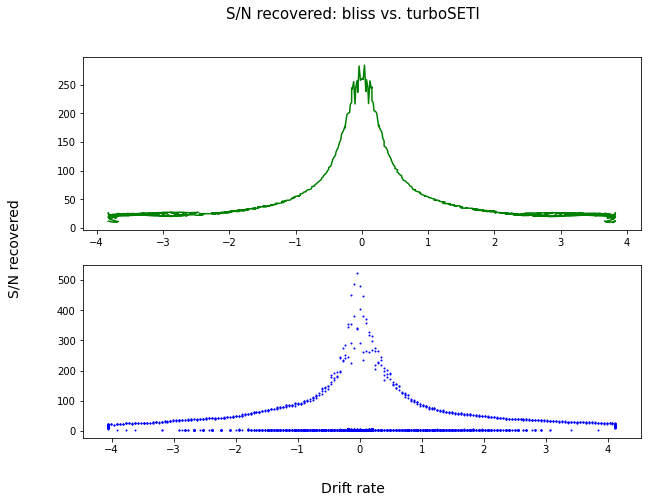

In [127]:
%matplotlib inline
# Grabbing some of my injected files, the same ones I used for the plot in Choza et al 2023 and the hyperseti test plot in the pipelines memo
base_file = '/datag/pipeline/AGBT21A_996_49/blc03/blc03_guppi_59411_54700_UGCA127_0095.rawspec.0000.h5'

test_string = 'x_drifting_center_1000_10p_2w'
coarse_channel_files = ['/datax/scratch/cgchoza/sigrec/' + f for f in os.listdir('/datax/scratch/cgchoza/sigrec') if test_string in f and 'inserted' in f and '.h5' in f]

# Grab turboSETI outputs from the same set for comparison
turbo_results = pd.read_csv(f'/datax/scratch/cgchoza/sigrec/post_insertion_hits_{test_string}.csv')

# Load in the hits files 

all_hits = []
hits_dir = '/datax/scratch/cgchoza/bliss_demo'
hits_files = os.listdir(hits_dir)
for idx, file in enumerate(hits_files):
    hits_file_path = os.path.join(hits_dir, file)
    scan_hits = pybliss.io.read_scan_hits_from_file(hits_file_path)
    print(scan_hits.hits)
    all_hits.extend(scan_hits.hits)


drifts = [hit.drift_rate_Hz_per_sec for hit in all_hits if hit.snr < 2000000]
snrs = [np.sqrt(hit.snr) for hit in all_hits if hit.snr < 2000000]
freqs = [hit.start_freq_MHz for hit in all_hits if hit.snr < 2000000]
bandwidths = [hit.bandwidth for hit in all_hits if hit.snr < 2000000]


tsnr = np.array(turbo_results["SNR"].values.tolist())[np.where((np.array(turbo_results["SNR"] > 3)))]
tdrift = np.array(turbo_results["Drift_Rate"].values.tolist())[np.where((np.array(turbo_results["SNR"] > 3)))]



fig, ab = plt.subplots(2, figsize=(10,7))

fig.suptitle('S/N recovered: bliss vs. turboSETI', fontsize=15)

ab[0].plot(tdrift, tsnr, color = 'green')
ab[1].plot(drifts, snrs, 'bo', markersize = 1)

fig.supylabel("S/N recovered", fontsize=14)
fig.supxlabel("Drift rate", fontsize=14)

plt.savefig("snr_recovered_drift_varying.png")
    


In [ ]:
# 

In [ ]:
# good_comparison_file = '/mnt_blpc1/datax/scratch/calebp/HIP70497/lband/blc40_guppi_60095_70975_HIP70497_0100.rawspec.0000.h5'

# fchans = 1048576
# f_begin = None
# f_shift = 1048576
# f_end = None
# generator = waterfall_generator(good_comparison_file, fchans, f_begin=f_begin, _end=f_end, f_shift=f_shift)